# 遷移學習Transfer Learning
在人類的學習過程中，我們常常會從之前任務學習到的知識與經驗，套用到目前的任務上，這就稱為「遷移學習」。遷移學習是一種機器學習技術，可以將原來針對先前任務所建立的已訓練模型，直接使用並微調，來訓練出解決其他相關任務的模型。

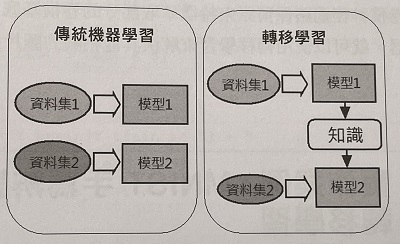

上圖中，傳統機器學習有兩個任務，需要準備對應的兩組資料來訓練出兩個模型。如果這兩種任務有相關且類似，可以使用遷移學習。先使用第一個訓練資料集訓練出第一個模型，然後將其學習到的部分權重（即知識），轉移至第二個相關任務來運用。如此，我們只需要少量第二種資料集，就可以訓練出第二個模型。

## 遷移學習為何有用
對於深度學習的CNN來說，神經網路可以分成兩部分：
1. **卷積基底 Convolutional Base**: 使用多組卷積和池化層開始的神經層，可以執行特徵萃取。
2. **分類器 Classifier**: 在卷積基底之後使用的是Dense全連接層建立的分類器。

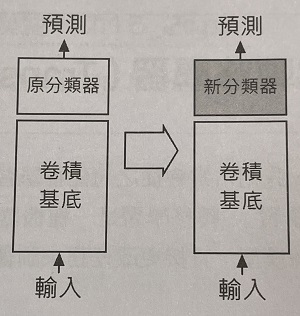

越前面（底部）的卷積層，學到的特徵越泛化，這些**高泛化特徵並不會因為不同的訓練資料集而訓練出不同的結果**。所以學到這些特徵，可以轉移至其他相關的圖片分類問題。上圖顯示，CNN保留原來特徵萃取用的卷積基底，轉移到另一個CNN架構。我們只需更改第二個CNN頂部的分類器，就可以解決其他相關的圖片分類問題。

下圖則是示意圖，在遷移模型後，會凍結卷積層的權重而不訓練。需要訓練的是我們自行設計的頂部分類器，其中全連接層之間的權重會被訓練。


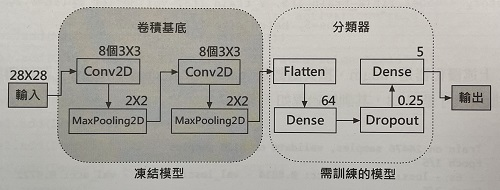

### 實作案例：預訓練模型的遷移學習
我們在MobileNet預訓練模型的卷積基底上新增我們自己設計的Dense層分類器。

注意：因為需要調整放大cifar10的圖片尺寸（MobileNetV2模型所輸入的圖片尺寸為224*224），記憶體大小需要16GB以上。在Colab上有可能因為記憶體不足而無法執行。

In [ ]:
import numpy as np
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from PIL import Image

In [ ]:
# 指定亂數種子
seed = 10
np.random.seed(seed)
# 載入資料集
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
# 打亂 2 個 Numpy 陣列
def randomize(a, b):
  permutation = list(np.random.permutation(a.shape[0]))
  shuffled_a = a[permutation]
  shuffled_b = b[permutation]
  
  return shuffled_a, shuffled_b

In [ ]:
X_train, Y_train = randomize(X_train, Y_train)
X_test, Y_test = randomize(X_test, Y_test)
# 只取用5000張圖片進行訓練, 1000張進行測試
X_train = X_train[:5000]
Y_train = Y_train[:5000]
X_test = X_test[:1000]
Y_test = Y_test[:1000]
# One-hot編碼
Y_train = to_categorical(Y_train, 10)
Y_test = to_categorical(Y_test, 10)

In [ ]:
# 調整X_train的圖片尺寸
print("調整X_train的圖片尺寸...")
X_train_new = np.array(
  [np.asarray(Image.fromarray(X_train[i]).resize((224, 224))) for i in range(0, len(X_train))])
X_train_new = X_train_new.astype("float32")
# 訓練資料的資料前處理 
train_input = preprocess_input(X_train_new)

調整X_train的圖片尺寸...


In [ ]:
# 調整X_test的圖片尺寸
print("調整X_test的圖片尺寸...")
X_test_new = np.array(
  [np.asarray(Image.fromarray(X_test[i]).resize((224, 224))) for i in range(0, len(X_test))])
X_test_new = X_test_new.astype("float32")
# 測試資料的資料前處理
test_input = preprocess_input(X_test_new)

調整X_test的圖片尺寸...


In [ ]:
# 載入 MobileNetV2 模型
mobilenet_model = MobileNetV2(weights="imagenet",
                include_top=False,
                input_shape=(224, 224, 3))

In [ ]:
# 定義模型
model = Sequential()
model.add(mobilenet_model)
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())    #這裡使用平均池化層取代傳統用的平坦層，目的是減少模型的參數量。
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))

In [ ]:
# 凍結底部的卷積基底模型（也就是mobilenet_v2的模型）
mobilenet_model.trainable = False

In [ ]:
model.summary()   # 顯示模型摘要資訊

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 7, 7, 1280)        0         
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-tra

In [ ]:
# 編譯模型
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
# 訓練模型
history = model.fit(train_input, Y_train, validation_data=(test_input, Y_test), epochs=20, batch_size=16, verbose=2)

Epoch 1/20
313/313 - 23s - loss: 1.2943 - accuracy: 0.5842 - val_loss: 0.6423 - val_accuracy: 0.7840 - 23s/epoch - 72ms/step
Epoch 2/20
313/313 - 8s - loss: 0.7370 - accuracy: 0.7560 - val_loss: 0.6069 - val_accuracy: 0.8040 - 8s/epoch - 26ms/step
Epoch 3/20
313/313 - 8s - loss: 0.6268 - accuracy: 0.7892 - val_loss: 0.5457 - val_accuracy: 0.8200 - 8s/epoch - 26ms/step
Epoch 4/20
313/313 - 8s - loss: 0.5726 - accuracy: 0.8080 - val_loss: 0.5616 - val_accuracy: 0.8030 - 8s/epoch - 27ms/step
Epoch 5/20
313/313 - 8s - loss: 0.5544 - accuracy: 0.8120 - val_loss: 0.5522 - val_accuracy: 0.8100 - 8s/epoch - 27ms/step
Epoch 6/20
313/313 - 9s - loss: 0.5088 - accuracy: 0.8322 - val_loss: 0.5268 - val_accuracy: 0.8260 - 9s/epoch - 27ms/step
Epoch 7/20
313/313 - 8s - loss: 0.5035 - accuracy: 0.8282 - val_loss: 0.4976 - val_accuracy: 0.8290 - 8s/epoch - 27ms/step
Epoch 8/20
313/313 - 8s - loss: 0.5039 - accuracy: 0.8322 - val_loss: 0.5065 - val_accuracy: 0.8250 - 8s/epoch - 27ms/step
Epoch 9/20
313

In [ ]:
# 評估模型
print("\nTesting ...")
loss, accuracy = model.evaluate(test_input, Y_test, verbose=0)
print("測試資料集的準確度 = {:.2f}".format(accuracy))


Testing ...
測試資料集的準確度 = 0.83


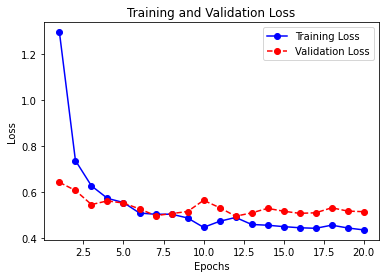

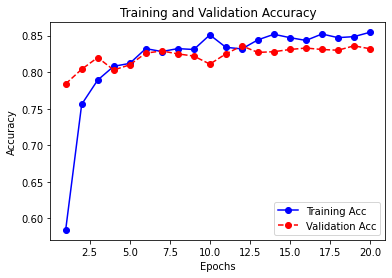

In [ ]:
# 顯示圖表來分析模型的訓練過程
import matplotlib.pyplot as plt
# 顯示訓練和驗證損失
loss = history.history["loss"]
epochs = range(1, len(loss)+1)
val_loss = history.history["val_loss"]
plt.plot(epochs, loss, "bo-", label="Training Loss")
plt.plot(epochs, val_loss, "ro--", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
# 顯示訓練和驗證準確度
acc = history.history["accuracy"]
epochs = range(1, len(acc)+1)
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo-", label="Training Acc")
plt.plot(epochs, val_acc, "ro--", label="Validation Acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()